# exp1

In [2]:
!touch hoge/test.txt

In [1]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [3]:
# ====================================================
# Directory settings
# ====================================================

EXP_NAME = "ORIGIN"
import os
import datetime

# INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
INPUT_DIR = "../../data/us-patent-phrase-to-phrase-matching/"
dt_now = datetime.datetime.now()

date =dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/{date}'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [4]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=8
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]
    

In [5]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0
# !pip install nltk

# Library

In [6]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
import nltk
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

start = time.time()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.0
transformers.__version__: 4.16.2
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [7]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [8]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


id     anchor                  target context  score
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75
2  36d72442aefd8232  abatement         active catalyst     A47   0.25
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00

id              anchor                         target context
0  4112d61851461f60            opc drum  inorganic photoconductor drum     G02
1  09e418c93a776564     adjust gas flow              altering gas flow     F23
2  36baf228038e314b      lower trunnion                 lower locating     B60
3  1f37ead645e7f0c8       cap component                  upper portion     D06
4  71a5b6ad068d531f  neural stimulation      artificial neural network     H04

id  score
0  4112d61851461f60      0
1  09e418c93a776564      0
2  36baf228038e314b      0
3  1f37ead645e7f0c8      0
4  71a5b6ad068d531f      0

In [9]:
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")

train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

id     anchor                  target context  score                                       context_text
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50  HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75  HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2  36d72442aefd8232  abatement         active catalyst     A47   0.25  HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50  HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00  HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...

id              anchor                         target context                                       context_text
0  4112d61851461f60            opc drum  inorganic photoconductor drum     G02                                    PHYSICS. OPTICS
1  09e418c93a776564     adjust gas flow              altering gas flow     F23  MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2  36baf228038e314b      lower trunnion                 lower locating     B60  PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3  1f37ead645e7f0c8       cap component                  upper portion     D06  TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4  71a5b6ad068d531f  neural stimulation      artificial neural network     H04      ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE

In [10]:
from nltk import stem
from tqdm.notebook import tqdm

stemmer = stem.PorterStemmer()
# same_stems = []
# # for col in ["anchor", "target"]:
# #     stems = []
# if True:
#     for anchors, targets in tqdm(zip(train["anchor"].values, train["target"].values),total=train.shape[0]):
# #     for words in zip(train["anchor"].values, train["target"].values):
#         anchor = " ".join([stemmer.stem(word) for word in anchors.split(" ")])
#         target = " ".join([stemmer.stem(word) for word in targets.split(" ")])

#         same_stem = list(set(anchor)&set(target))
#         same_stems.append(" ".join(same_stems))
# #     # same_stems_num.append(len(same_stem))
# # del anchors, targets

# # train["same_stem"] = same_stems
# # del same_stems

# train["same_stem_num"] = same_stems_num

In [11]:
# from nltk import stem
# from tqdm.notebook import tqdm
# stemmer = stem.PorterStemmer()

# for col in ["anchor", "target"]:
#     train[f"{col}_stem"] = train[col].apply(lambda words: [stemmer.stem(word) for word in words])

# for col in ["anchor", "target"]:
#     stems = []
#     for words in train[col].values:
#         stems.append([stemmer.stem(word) for word in words.split(" ")])
#     train[f"{col}_stem"] = stems
    
# same_stems = []
# same_stems_num = []
# for anchor, target in zip(train.anchor_stem.values, train.target_stem.values):
#     same_stem = list(set(anchor)&set(target))
#     same_stems.append(" ".join(same_stem))
    
# train["same_stem"] = same_stems


#ビニング処理,データをbin数でグループ分けする
num_bins = int(np.floor(1 + np.log2(len(train))))
train.loc[:,'bins'] = pd.cut(train['score'],bins=num_bins,labels=False)

bins = train.bins.to_numpy()
bins

array([ 7, 11,  3, ...,  7, 11,  7])

In [12]:
from nltk import stem
from tqdm.notebook import tqdm
stemmer = stem.PorterStemmer()

for col in ["anchor", "target"]:
    test[f"{col}_stem"] = test[col].apply(lambda words: [stemmer.stem(word) for word in words])

for col in ["anchor", "target"]:
    stems = []
    for words in test[col].values:
        stems.append([stemmer.stem(word) for word in words.split(" ")])
    test[f"{col}_stem"] = stems
    
same_stems = []
same_stems_num = []
for anchor, target in zip(test.anchor_stem.values, test.target_stem.values):
    same_stem = list(set(anchor)&set(target))
    same_stems.append(" ".join(same_stem))
    # same_stems_num.append(len(same_stem))
    
# test["same_stem"] = same_stems
# train["same_stem_num"] = same_stems_num

In [13]:
train['text'] = train['anchor'] + '[SEP]' + train['target']  + '[SEP]' +  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'   + test['context_text']
display(train.head())
display(test.head())

id     anchor                  target context  score                                       context_text  bins                                               text
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50  HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...     7  abatement[SEP]abatement of pollution[SEP]HUMAN...
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75  HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...    11  abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2  36d72442aefd8232  abatement         active catalyst     A47   0.25  HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...     3  abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50  HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...     7  abatement[SEP]eliminating process[SEP]HUMAN NE...
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00  HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...     0  abatement[SEP]forest region[SEP]HUMAN NECESSIT...

id              anchor                         target context                                       context_text         anchor_stem                      target_stem                                               text
0  4112d61851461f60            opc drum  inorganic photoconductor drum     G02                                    PHYSICS. OPTICS         [opc, drum]  [inorgan, photoconductor, drum]  opc drum[SEP]inorganic photoconductor drum[SEP...
1  09e418c93a776564     adjust gas flow              altering gas flow     F23  MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...  [adjust, ga, flow]                [alter, ga, flow]  adjust gas flow[SEP]altering gas flow[SEP]MECH...
2  36baf228038e314b      lower trunnion                 lower locating     B60  PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...   [lower, trunnion]                   [lower, locat]  lower trunnion[SEP]lower locating[SEP]PERFORMI...
3  1f37ead645e7f0c8       cap component                  upper portion     D06  TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...       [cap, compon]                 [upper, portion]  cap component[SEP]upper portion[SEP]TEXTILES; ...
4  71a5b6ad068d531f  neural stimulation      artificial neural network     H04      ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE    [neural, stimul]      [artifici, neural, network]  neural stimulation[SEP]artificial neural netwo...

# EDA

<AxesSubplot:>

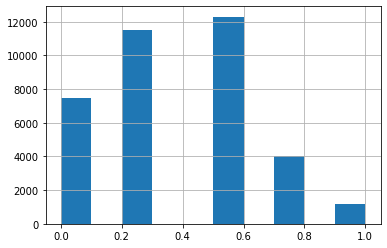

In [14]:
train['score'].hist()

In [15]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [16]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [17]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [18]:
# !pip install --no-cache-dir sentencepiece

In [19]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [20]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target', ]:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [21]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label
    
    
class CLRPDataset(Dataset):
    def __init__(self,df,tokenizer):
        self.text = df['text'].to_numpy()
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.text[idx],return_tensors='pt',
                                max_length=CFG.max_len,
                                padding='max_length',truncation=True)
        return encode
    
    def __len__(self):
        return len(self.text)

In [22]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [23]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

In [24]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim

        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))

        score = self.V(att)

        attention_weights = torch.softmax(score, dim=1)

        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector
    
class EmbModel(nn.Module):
    def __init__(self):
        super(EmbModel,self).__init__()
        # self.roberta = AutoModel.from_pretrained('../input/clrp-pytorch-roberta-pretrain-roberta-large/clrp_roberta_large/')  
        self.roberta = AutoModel.from_pretrained('../../data/us-patent-phrase-to-phrase-matching/clrp_roberta_large/')  
        #changed attentionHead Dimension from 768 to 1024 by changing model from roberta-base to roberta-large
        self.head = AttentionHead(1024,1024,1)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.head.out_features,1)

    def forward(self,**xb):
        x = self.roberta(**xb)[0]
        x = self.head(x)
        return x
    
def get_embeddings(df,path,plot_losses=True, verbose=True):
    #cuda使えたら使う構文
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{device} is used")
            
    model = EmbModel()
    # model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    
    # tokenizer = AutoTokenizer.from_pretrained('../input/clrp-pytorch-roberta-pretrain-roberta-large/clrp_roberta_large/')
    # tokenizer = AutoTokenizer.from_pretrained('../input/clrp_roberta_large/')
    tokenizer = CFG.tokenizer
    ds = CLRPDataset(df,tokenizer)
    dl = DataLoader(ds,
                  batch_size = CFG.batch_size,
                  shuffle=False,
                  num_workers = 4,
                  pin_memory=True,
                  drop_last=False
                 )
        
    #以下でpredictionsを抽出するために使った構文を使ってembeddingsをreturnしている.
    #SVMの手法とは、embeddingsの意味は？
    embeddings = list()
    with torch.no_grad():
        for i, inputs in tqdm(enumerate(dl)):
            inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
            outputs = model(**inputs)
            outputs = outputs.detach().cpu().numpy()
            embeddings.extend(outputs)
    return np.array(embeddings)



def get_svm(fold):
    model_path = f'../input/clrp-pytorch-roberta-finetune-roberta-large/model{fold}/model{fold}.bin'
    train_embeddings =  get_embeddings(train,model_path)
    test_embeddings = get_embeddings(test,model_path)
    train_svm,svm_preds = get_preds_svm(train_embeddings,target,test_embeddings)
    return train_svm,svm_preds


def get_preds_svm(X,y,X_test,bins=bins,nfolds=10,C=10,kernel='rbf'):
    scores = list()
    train_preds = np.zeros((X.shape[0]))
    preds = np.zeros((X_test.shape[0]))
    
    kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
    for k, (train_idx,valid_idx) in enumerate(kfold.split(X,bins)):
        model = SVR(C=C,kernel=kernel,gamma='auto')
        X_train,y_train = X[train_idx], y[train_idx]
        X_valid,y_valid = X[valid_idx], y[valid_idx]
        
        model.fit(X_train,y_train)
        prediction = model.predict(X_valid)
        train_preds[valid_idx] = prediction
        score = get_score(prediction,y_valid)
        pd.to_pickle(model, f"output_{score}.pkl")
        print(f'Fold {k} , score: {score}')
        scores.append(score)
        preds += model.predict(X_test)
        
    print("meanScore",np.mean(scores))
    return train_preds,np.array(preds)/nfolds


In [25]:
train_svm_list = []
test_svm_list = []
os.makedirs("output", exist_ok=True)
for fold in range(5):
    train_svm,svm_preds = get_svm(fold)
    train_svm_list.append(train_svm)
    test_svm_list.append(svm_preds)

cuda is used


Some weights of the model checkpoint at ../../data/us-patent-phrase-to-phrase-matching/clrp_roberta_large/ were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ../../data/us-patent-phrase-to-phrase-matching/clrp_roberta_large/ and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.poole

0it [00:00, ?it/s]

/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [103,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [103,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [103,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [103,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [103,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [103,0,0], thread: [101,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [ ]:
train_svm = np.array(train_svm_list).mean(axis=0)


In [ ]:
def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')